This notebook does a similar figure than Fig. A.2 of Ginolin+25b. This figure shows that on a typical SN Ia standardisation problem a regular loglikelihood fitting code will output biased standardisation parameters, while the total-$\chi^2$ method (as in the module `standax`) outputs unbiased estimates of $\alpha$, $\beta$ and $\gamma$. 
The SN simulations are run using the `skysurvey` package (https://skysurvey.readthedocs.io/).

Note that it will not reproduce the exact same figure as the SN Ia modelling used in this notebook paper is quite simple, whereas the one in the paper includes correlations between SN Ia properties and their environment. This modelling is a work in progress and thus not yet public, but will be the subject of a dedicated paper.

In [1]:
import warnings
import skysurvey
from scipy import stats
from jax import tree_util
import jax.numpy as jnp
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import standax

In [2]:
SIMULATION_MODEL = dict( redshift = {"kwargs": {"zmax":0.2}, "as":"z"},
                              
                   x1 = {"func": skysurvey.target.snia.SNeIaStretch.nicolas2021, 
                        "kwargs": {"xx":"-4:4:0.005", "mu1":0.42, "sigma1":0.54, 
                     "mu2":-1.24, "sigma2":0.73, "a":0.2,
                     "fprompt":0.5}}, 
                   
                   c = {"func": skysurvey.target.snia.SNeIaColor.intrinsic_and_dust,
                       "kwargs": {"xx":"-0.3:1:0.001", "cint":-0.085, "sigmaint":0.03, "tau":0.155}},

                   t0 = {"func": np.random.uniform, 
                         "kwargs": {"low":56_000, "high":56_200} },

                    isup = {"func": np.random.binomial, 
                         "kwargs": {"n":1, "p":0.5} },
                       
                   magabs = {"func": skysurvey.target.snia.SNeIaMagnitude.tripp_and_step,
                             "kwargs": {"x1": "@x1", "c": "@c", "isup": "@isup",
                                        "mabs":-19.3}
                            },
                           
                   magobs = {"func": "magabs_to_magobs", # str-> method of the class
                             "kwargs": {"z":"@z", "magabs":"@magabs"},
                            },

                   x0 = {"func": "magobs_to_amplitude", # str-> method of the class
                         "kwargs": {"magobs":"@magobs", "param_name": "x0"},
                        }, #because it needs to call sncosmo_model.get(param_name)
                       
                   radec = {"func": skysurvey.tools.utils.random_radec,
                            "kwargs": {},
                            "as": ["ra","dec"]
                           },
                    )

ERROR_MODEL = {"x1": {"func":stats.lognorm.rvs, "kwargs": dict(s=0.597, loc=0.0008, scale=0.1673) },
                "c":  {"func":stats.lognorm.rvs, "kwargs": dict(s=0.6976, loc=0.0243, scale=0.0086) },
                "magobs":  {"func":stats.lognorm.rvs, "kwargs": dict(s=0.882, loc=0.0309, scale=0.007)}}

def get_simulation(size, model=SIMULATION_MODEL, errmodel=ERROR_MODEL,
                   truth={}, zmax=0.06, **kwargs):
    """ """
    # Truth
    snia = skysurvey.SNeIa.from_draw(size,  zmax=zmax, model=model, magabs=truth, **kwargs)
    # noise
    snianoisy = snia.apply_gaussian_noise(errmodel)

    return snianoisy.data

def get_standax_parameters(data, start_params):
    """ """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        new_data = pandas.DataFrame({'redshift': np.array(data['z']), 'x1':np.array(data['x1']),
    'x1_err':np.array(data['x1_err']), 'c':np.array(data['c']), 'c_err':np.array(data['c_err']), 
    'cov_x1_c':np.zeros(len(data))*1., 'cov_x0_x1':np.zeros(len(data))*1., 'cov_x0_c':np.zeros(len(data))*1., 
    'mag':np.array(data['magobs']), 'mag_err':np.array(data['magobs_err']), 'isup':np.array(data['isup']), 
    'x0':data['x0']})
        bl = standax.hubble.HubbleResiduals.from_dataset(new_data)
        bl.set_block_hubble_const(False)
        bl.set_fit_method('standax')
        bl.set_stepmask(np.array(new_data["isup"]==True))
        bl.fit_step(guess_sigma=start_params['sigmaint'], guess_beta=start_params['beta'], guess_alpha=start_params['alpha'],
                    guess_step=start_params['gamma'], smooth_step=False, force_sigmaint=False)
    
    return jnp.asarray([bl.alpha, bl.alpha_err, bl.beta, bl.beta_err, bl.step, bl.step_err, bl.sn_scatter])

def get_loglikelihood_parameters(data, start_params):
    """ """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        new_data = pandas.DataFrame({'redshift': np.array(data['z']), 'x1':np.array(data['x1']),
    'x1_err':np.array(data['x1_err']), 'c':np.array(data['c']), 'c_err':np.array(data['c_err']), 
    'cov_x1_c':np.zeros(len(data))*1., 'cov_x0_x1':np.zeros(len(data))*1., 'cov_x0_c':np.zeros(len(data))*1., 
    'mag':np.array(data['magobs']), 'mag_err':np.array(data['magobs_err']), 'isup':np.array(data['isup']), 
    'x0':data['x0']})
        bl = standax.hubble.HubbleResiduals.from_dataset(new_data)
        bl.set_block_hubble_const(False)
        bl.set_fit_method('loglikelihood')
        bl.set_stepmask(np.array(new_data["isup"]==True))
        bl.fit_step(guess_sigma=start_params['sigmaint'], guess_beta=start_params['beta'], guess_alpha=start_params['alpha'],
                    guess_step=start_params['gamma'], smooth_step=False, force_sigmaint=False)
    
    return jnp.asarray([bl.alpha, bl.alpha_err, bl.beta, bl.beta_err, bl.step, bl.step_err, bl.sn_scatter])


# Black magic for parameter scan
def mesh_kwargs(**kwargs):
    """
    Create a dataframe with all parameter combinations.

    >>> mesh_kwargs(scale=[0.02, 0.05], sigma=[0.03, 0.06])
       scale  sigma
    0   0.02   0.03
    1   0.05   0.03
    2   0.02   0.06
    3   0.05   0.06
    """

    scan_params = list(kwargs.keys())     # (npar,)
    # Number of scanned parameters (i.e. columns in final df)
    # npar = len(scan_params)

    mesh = np.meshgrid(*kwargs.values())  # npar × (nval1, nval2, ...)
    mshape = np.shape(mesh)               # (npar, nval1, nval2, ...)
    shape = (mshape[0], np.prod(mshape[1:]))  # (npar, nval1*nval2*...)
    df_params = pandas.DataFrame(
        np.reshape(mesh, shape).T,        # (nval1*nval2*..., npar)
        columns=scan_params)              # (npar,)

    return df_params

# Simple ZTF DR2-like simulations

### Option 1: running the sims in the notebook

This might be a bit long depending on how much simulations you want. For one permutation of the parameters ($\alpha$, $\beta$, $\gamma$ and $\sigma_\mathrm{int}$), ie 81 simulations, it will take around 30 mins.

In [3]:
df_config = mesh_kwargs(alpha=[-0.2, -0.15, -0.1], 
                        beta=[2.5, 3.5, 4.5], 
                        gamma=[0.0, 0.1, 0.2], 
                        sigmaint=[0.07, 0.12, 0.17])

In [4]:
nreal = 1 # The total number of sims will be nreal*81

In [5]:
simparams_loglikelihood = []
for n in range(nreal):
    for i, config_ in tqdm(df_config.iloc[:].iterrows()):
        simu = get_simulation(size=2_000, truth=config_.to_dict())
        params = get_loglikelihood_parameters(simu, config_.to_dict())
        simparams_loglikelihood.append(params)

81it [00:36,  2.22it/s]


In [6]:
simparams_totalchi2 = []
for n in range(nreal):
    for i, config_ in tqdm(df_config.iloc[:].iterrows()):
        simu = get_simulation(size=2_000, truth=config_.to_dict())
        params = get_standax_parameters(simu, config_.to_dict())
        simparams_totalchi2.append(params)

81it [32:43, 24.25s/it]


In [7]:
df_config.rename(columns={'alpha':'alpha_true', 'beta':'beta_true', 'gamma':'gamma_true'}, inplace=True)
new_config = pandas.concat([df_config, df_config, df_config, df_config, df_config])
new_config = new_config.set_index(pandas.Index(np.linspace(0, 404, 405, dtype=int)))

In [8]:
results_logl = pandas.DataFrame(simparams_loglikelihood, columns=['alpha', 'alpha_err', 'beta', 'beta_err', 'step', 'step_err', 'sigma'])
results_logl = results_logl.merge(new_config, left_index=True, right_index=True)

In [9]:
results_totalchi2 = pandas.DataFrame(simparams_totalchi2, columns=['alpha', 'alpha_err', 'beta', 'beta_err', 'step', 'step_err', 'sigma'])
results_totalchi2 = results_totalchi2.merge(new_config, left_index=True, right_index=True)

### Option 2: loading sims 

This loads simulations done with the code in this notebook, with `nreal=5`, corresponding to 405 simulations, like in Fig. A.2 of Ginolin+25b.

# Plotting

Computing the pulls for each parameters.

In [10]:
results_logl['pull_alpha'] = (results_logl['alpha']+results_logl['alpha_true'])/results_logl['alpha_err']
results_logl['pull_beta'] = (results_logl['beta']-results_logl['beta_true'])/results_logl['beta_err']
results_logl['pull_gamma'] = (results_logl['step']-results_logl['gamma_true'])/results_logl['step_err']

In [11]:
pulls_alpha = np.array([results_logl['pull_alpha'][results_logl['alpha_true'] == -0.2],
                      results_logl['pull_alpha'][results_logl['alpha_true'] == -0.15],
                      results_logl['pull_alpha'][results_logl['alpha_true'] == -0.1]])
pulls_beta = np.array([results_logl['pull_beta'][results_logl['beta_true'] == 2.5],
                      results_logl['pull_beta'][results_logl['beta_true'] == 3.5],
                      results_logl['pull_beta'][results_logl['beta_true'] == 4.5]])
pulls_gamma = np.array([results_logl['pull_gamma'][results_logl['gamma_true'] == 0],
                      results_logl['pull_gamma'][results_logl['gamma_true'] == 0.1],
                      results_logl['pull_gamma'][results_logl['gamma_true'] == 0.2]])

In [12]:
results_totalchi2['pull_alpha'] = (results_totalchi2['alpha']+results_totalchi2['alpha_true'])/results_totalchi2['alpha_err']
results_totalchi2['pull_beta'] = (results_totalchi2['beta']-results_totalchi2['beta_true'])/results_totalchi2['beta_err']
results_totalchi2['pull_gamma'] = (results_totalchi2['step']-results_totalchi2['gamma_true'])/results_totalchi2['step_err']

In [13]:
pulls_alpha_totalchi2 = np.array([results_totalchi2['pull_alpha'][results_totalchi2['alpha_true'] == -0.2],
                      results_totalchi2['pull_alpha'][results_totalchi2['alpha_true'] == -0.15],
                      results_totalchi2['pull_alpha'][results_totalchi2['alpha_true'] == -0.1]])
pulls_beta_totalchi2 = np.array([results_totalchi2['pull_beta'][results_totalchi2['beta_true'] == 2.5],
                      results_totalchi2['pull_beta'][results_totalchi2['beta_true'] == 3.5],
                      results_totalchi2['pull_beta'][results_totalchi2['beta_true'] == 4.5]])
pulls_gamma_totalchi2 = np.array([results_totalchi2['pull_gamma'][results_totalchi2['gamma_true'] == 0],
                      results_totalchi2['pull_gamma'][results_totalchi2['gamma_true'] == 0.1],
                      results_totalchi2['pull_gamma'][results_totalchi2['gamma_true'] == 0.2]])

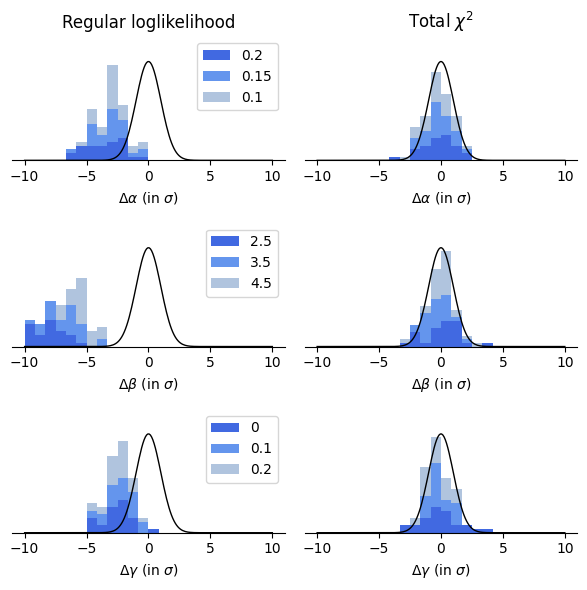

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(6,6))

xsig = np.linspace(-10, 10, 200)
sigbins = np.linspace(-10, 10, 25)

ax[0,0].hist(pulls_alpha.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['0.2', '0.15', '0.1'])
ax[1,0].hist(pulls_beta.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['2.5', '3.5', '4.5'])
ax[2,0].hist(pulls_gamma.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['0', '0.1', '0.2'])

ax[0,1].hist(pulls_alpha_totalchi2.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['0.2', '0.15', '0.1'])
ax[1,1].hist(pulls_beta_totalchi2.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['2.5', '3.5', '4.5'])
ax[2,1].hist(pulls_gamma_totalchi2.reshape(27*nreal, 3), bins=sigbins, stacked=True, color=['royalblue', 'cornflowerblue', 'lightsteelblue'], density=True,
          label=['0', '0.1', '0.2'])

ax[0,0].set_title('Regular loglikelihood')
ax[0,1].set_title(r'Total $\chi^2$')

for i in range (3):
    ax[i,0].legend(loc='upper right', ncols=1)
    for j in range(2):
        ax[i,j].plot(xsig, norm.pdf(xsig, 0, 1), c='Black', lw=1)
        ax[i,j].set_ylim(0, 0.5)
        ax[i,j].spines['left'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].set_yticks([])

ax[0,0].set_xlabel(r'$\Delta \alpha$ (in $\sigma$)')
ax[1,0].set_xlabel(r'$\Delta \beta$ (in $\sigma$)')
ax[2,0].set_xlabel(r'$\Delta \gamma$ (in $\sigma$)')
ax[0,1].set_xlabel(r'$\Delta \alpha$ (in $\sigma$)')
ax[1,1].set_xlabel(r'$\Delta \beta$ (in $\sigma$)')
ax[2,1].set_xlabel(r'$\Delta \gamma$ (in $\sigma$)')

fig.tight_layout()

plt.show()